In [ ]:
# Importing Libraries
from matplotlib import colors 
from matplotlib.ticker import PercentFormatter 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
from scipy.integrate import solve_ivp
import scipy.optimize as opt
import math
import statistics as st

In [1]:
## Trial Conditions 
global gluecose 
gluecose = 20 #g
yeast_extract = 20 #g
peptone = 10 #g

In [ ]:
# Import Data
from google.colab import files
uploaded = files.upload()

Saving 19122022.xlsx to 19122022.xlsx


In [ ]:
trial_1 = pd.read_excel('19122022.xlsx')
trial_1

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,NaN,Biocal_12192022: Data Log All Items Report,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Time Stamp,NaN,Loop Name,NaN,Setpoint,NaN,Process value,NaN,Output,NaN,Mode,NaN,Units
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30000,24:55:28,NaN,pH_1M,NaN,7,NaN,5.05355,NaN,0,NaN,Off,NaN,pH
30001,24:55:28,NaN,Pump1_1M,NaN,0,NaN,0,NaN,0,NaN,Off,NaN,%
30002,24:55:28,NaN,Pump2_1M,NaN,0,NaN,0,NaN,0,NaN,Off,NaN,%
30003,24:55:28,NaN,Pump3_1M,NaN,0,NaN,0,NaN,0,NaN,Off,NaN,%


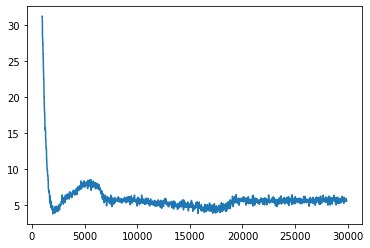

In [ ]:
# Set "important_trial_x" to the actual time that corresponds to the experiment
# Check time stamp associated with the first 
# The time will be reindexed at the end

important_trial_1 = trial_1[trial_1["Unnamed: 2"] == "Temp_1M"][80:2490]
time =important_trial_1['Unnamed: 0']
temperature_output_trial_1 = important_trial_1['Unnamed: 8']
actual_temperature_1 = important_trial_1['Unnamed: 4']
plt.plot(temperature_output_trial_1)



In [ ]:
# Now we need to replace the first section of the data with the equilibrium data 
# This is due to the fact that the reactor did not reach equilirbium before the expriement was started

temperature_output_trial_1 = pd.DataFrame(temperature_output_trial_1)
temperature_output_trial_1.reset_index(drop=True, inplace = True)
baseline_data = temperature_output_trial_1[1500:2000]
temperature_output_trial_1['Unnamed: 8'][0:500] = baseline_data['Unnamed: 8']
datapoints = len(temperature_output_trial_1)

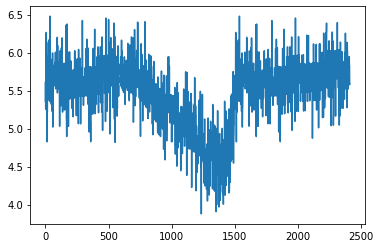

In [ ]:
plt.plot(temperature_output_trial_1)

In [ ]:
# Need to bring in a function that determines the growth parameters
# Creates the growth curve
# Used to get more datapoints to input into a machine learning algorithm rather then the actual data analysis 

def monod_eq(um, Ks, Kis, Y_xs, time):

    def f(t,y):
        A = y[0]
        B = y[1]
      
        dA_dt = A*um*B/((Ks)+B+(B**2)/Kis)
        dB_dt = -dA_dt/Y_xs

        return np.array([dA_dt, dB_dt]) 

  
    t_span = np.array([0,time])
    times = np.linspace(t_span[0], t_span[1], datapoints)
 

    # [Inital Cell Count (cells), Inital Gluecose (g)]
    y0 = np.array([6.060e+09,gluecose])

    soln = solve_ivp(f, t_span, y0, t_eval = times)
    t = soln.t
    A = soln.y[0]
    B = soln.y[1]

    df = pd.DataFrame(data = t,columns = ['t'] )
    df['A'] = A
    df['B'] = B

    return df

def monod_eq_learning(um, Ks, Kis, Y_xs):

    time = 24
    length = len(cells)
    def f(t,y):
        A = y[0]
        B = y[1]
      
        dA_dt = A*um*B/((Ks)+B+(B**2)/Kis) 
        dB_dt = -dA_dt/Y_xs

        return np.array([dA_dt, dB_dt]) 

  
    #t_span = np.array([0,time])
    #times = np.linspace(t_span[0], t_span[1], length)
 
    times = time_growth
    t_span = np.array([0,24])
    # [Inital Cell Count (cells), Inital Gluecose (g)]
    y0 = np.array([6.060e+09,gluecose])

    soln = solve_ivp(f, t_span, y0, t_eval = times)
    t = soln.t
    A = soln.y[0]
    B = soln.y[1]

    df = pd.DataFrame(data = t,columns = ['t'] )
    df['A'] = A
    df['B'] = B

    return df

def Contois_eq(um, Ks, Y_xs, time):
  
    def f(t,y):
        A = y[0]
        B = y[1]
      
        dA_dt = A*um*B/(Ks*A+B)
        dB_dt = -dA_dt/Y_xs

        return np.array([dA_dt, dB_dt]) 

    t_span = np.array([0,time])
    times = np.linspace(t_span[0], t_span[1], datapoints)
 

    # [Inital Cell Count (cells), Inital Gluecose (g)]
    y0 = np.array([6.060e+09,20])

    soln = solve_ivp(f, t_span, y0, t_eval = times)
    t = soln.t
    A = soln.y[0]
    B = soln.y[1]

    df = pd.DataFrame(data = t,columns = ['t'] )
    df['A'] = A
    df['B'] = B

    return df

def Contois_eq_learning(um, Ks, Y_xs):

    time = 24
    length = len(cells)
    def f(t,y):
        A = y[0]
        B = y[1]
      
        dA_dt = A*um*B/(Ks*A+B)
        dB_dt = -dA_dt/Y_xs

        return np.array([dA_dt, dB_dt]) 
 
    times = time_growth
    t_span = np.array([times[0],int(times[8])])
    # [Inital Cell Count (cells), Inital Gluecose (g)]
    y0 = np.array([6.060e+09,20])

    soln = solve_ivp(f, t_span, y0, t_eval = times)
    t = soln.t
    A = soln.y[0]
    B = soln.y[1]

    df = pd.DataFrame(data = t,columns = ['t'] )
    df['A'] = A
    df['B'] = B
    

    return df

def squared_error(par):
  # Start
  #Monod : um, Ks, Kis, Y_xs, Kd
 
    um = par[0]
    Ks = par[1]
    Kis = par[2]
    Y_xs = par[3]
    Kd = par[4]

    training_set = monod_eq_learning(um, Ks, Kis, Y_xs, Kd)
    test_set = cells

    sse = 0

    for i,row in training_set.iterrows():
        sse = sse + (training_set.iloc[(i,1)] - test_set[i])**2
        
    return sse

In [ ]:
# Use to determine the parameters of the growth equation
# Note that it is common for this to not converge due to the limited amount of points in the original dataset
# This is more for creating a machine learning dataset anyways 

#par_all = [um, Ks, Ysx, kd, time]
par_all = [6.48649907e+00, 2.05454913e+02, 2.87936960e+00, 2.31474291e+09]


#dataset = cells

# Test points are defined as monod equaion
#testpoints = monod_eq(um, Ks, Y_xs)

s_error = lambda p: squared_error(p)
solution = opt.minimize(s_error, par_all, method = 'Nelder-Mead', tol = 1e-6)
#options = {'maxiter':4000}
solution


IndexError: ignored

In [1]:
# Raw data taken from a spectrometer
# The "cells" value is taken from literature

time_growth = np.array([0, 1, 2, 3, 4, 5, 6, 7, 24]) # Times are in hours 
OD = np.array([0.202, 0.225, 0.341, 0.517, 0.771, 1.073, 1.341, 1.402, 1.754]) # OD600
cells = OD*2000*1.5*10**7

NameError: ignored

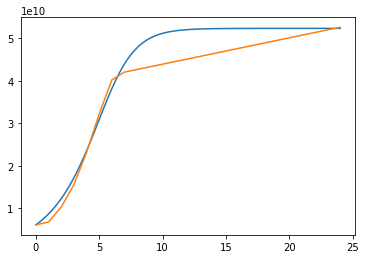

In [ ]:
# Just used to visualize the data 
#def monod_eq[um, Ks, Ysx, kd, time]:
testpoints = monod_eq(6.48649907e+00, 2.05454913e+02, 2.87936960e+00, 2.31474291e+09, 24)
plt.plot(testpoints['t'], testpoints['A'])
plt.plot(time_growth, cells)
#plt.ylim(0,0.5)
# We were able to determine the acturate growth parameters but now lets go back and add a ton of datapoints

In [ ]:
# This is to rewrite the HH:MM:SS time as time in hours so we can look at time in a plot 

t_actual = []

def get_sec(time_str):
    
  for i in range(len(time_str)):
    t = time.iloc[i].split(':')

    h, m, s = t[0], t[1], t[2]

    t_actual.append(int(h) + int(m) / 60 + int(s)/3600 - 0.33944444)
  return t_actual

t_actual = get_sec(time)


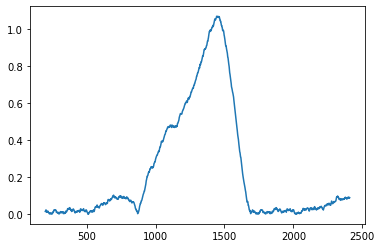

In [ ]:
# We need to find the inverse of the heat profile, setting the flat zones to zero 
zero = baseline_data.mean()
inverse_curve = abs(zero.values - (temperature_output_trial_1).rolling(200).mean())
growth_curve = np.cumsum(inverse_curve)

plt.plot(inverse_curve)

In [ ]:
# So now we have to figure out how this correlates to heat
# Remember that the goal is actually a black box model becuase things will change for each bioreactor 
# We want the amount of heat produced per cell produced
# So what we can do is say that (dheat/dt) = area under the heat curve 
#                               cells = total amount of cells grown 
# And then we are interested in a = cells/heat generated 
# We can then roll this into differentials but the problem with that is that the bioreactor cant 
  # see the heat generated early on or later on too well 
# Will it be posible to predict a??     

from scipy.integrate import simpson
from numpy import trapz


y_heat = inverse_curve['Unnamed: 8'][500:2010]
x_heat = t_actual[500:2010]

area_heat = trapz(y=y, x=x)
print("(dheat/dt)=", area_heat)


cells_produced = cells[8] - cells[0]

print("(dheat/dt)/(cells produced) =", area_heat/cells_produced)




(dheat/dt)= 1.9925493965928425
(dheat/dt)/(cells produced) = 4.279530490964009e-11


Text(0.5, 1.0, 'Trial 1')

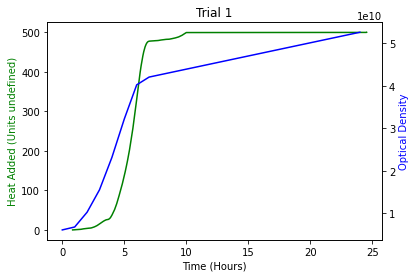

In [ ]:


fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(t_actual[200:2410], growth_curve[200:2410], 'g-')
ax2.plot(time_growth, cells, 'b-')

ax1.set_xlabel('Time (Hours)')
ax1.set_ylabel('Heat Added (Units undefined)', color='g')
ax2.set_ylabel('Optical Density', color='b')
plt.title("Trial 1")



In [ ]:
trial_1_clean = testpoints['t']
trial_1_clean = pd.DataFrame(trial_1_clean)
trial_1_clean['Cell Count'] = testpoints['A']
trial_1_clean['Heat Profile'] = temperature_output_trial_1['Unnamed: 8']
trial_1_clean.to_csv('trial_1_clean.csv')
download = files.download('trial_1_clean.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>